In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import re


### fixed variables
VOLUME_PER_IMAGE = 50 * (3.5)**2 * np.pi  # in cubic centimeters
VOLUME_PER_IMAGE_LITERS = VOLUME_PER_IMAGE / 1000  # convert to liters
IMAGE_SIZE = 2560

In [2]:
top6_validated_df = pd.read_csv("C:/Users/fanny/OneDrive - Van Hall Larenstein/HVHL/Year_IV/Thesis_Internship/ET_data/top6_biovolume_groups_validated_only.csv")

all_images_df = pd.read_csv("C:/Users/fanny/OneDrive - Van Hall Larenstein/HVHL/Year_IV/Thesis_Internship/ET_data/M181_all_images_metadata.csv")

C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\1831068691.py:1: DtypeWarning: Columns (0,51,62,63,70,74,75,76,77) have mixed types. Specify dtype option on import or set low_memory=False.
  top6_validated_df = pd.read_csv("C:/Users/fanny/OneDrive - Van Hall Larenstein/HVHL/Year_IV/Thesis_Internship/ET_data/top6_biovolume_groups_validated_only.csv")


In [3]:
# Summary of top6_validated_df
print("=== TOP6 VALIDATED DATAFRAME SUMMARY ===\n")

print(f"Shape: {top6_validated_df.shape}")
print(f"Columns: {list(top6_validated_df.columns)}\n")

print("=== SUMMARY STATISTICS ===")
print(top6_validated_df.describe())
print("\n")

=== TOP6 VALIDATED DATAFRAME SUMMARY ===

Shape: (32354, 86)
Columns: ['object_date-time', 'object_pressure', 'object_depth_min', 'object_temperature', 'object_index', 'img_rank', 'img_file_name', 'object_mean_raw', 'object_std_raw', 'object_mean', 'object_std', 'object_area', 'object_x', 'object_y', 'object_width', 'object_height', 'object_saved', 'object_bound_box_w', 'object_bound_box_h', 'object_bound_box_x', 'object_bound_box_y', 'object_circularity', 'object_area_exc', 'object_area_rprops', 'object_%area', 'object_major_axis_len', 'object_minor_axis_len', 'object_centroid_y', 'object_centroid_x', 'object_convex_area', 'object_min_intensity', 'object_max_intensity', 'object_mean_intensity', 'object_int_density', 'object_perimeter', 'object_elongation', 'object_range', 'object_perim_area_excl', 'object_perim_major', 'object_circularity_area_excl', 'object_angle', 'object_boundbox_area', 'object_eccentricity', 'object_equivalent_diameter', 'object_euler_nr', 'object_extent', 'object

In [4]:
# Create biovolume column from ESD
# Biovolume = (4/3) * π * (ESD/2)³ = (π/6) * ESD³
top6_validated_df['biovolume_mm3'] = (np.pi / 6) * (top6_validated_df['object_esd'] ** 3)

print("=== BIOVOLUME COLUMN ADDED ===")
print(f"New shape: {top6_validated_df.shape}")
print(f"Biovolume statistics:")
print(top6_validated_df['biovolume_mm3'].describe())
print("\n")

=== BIOVOLUME COLUMN ADDED ===
New shape: (32354, 87)
Biovolume statistics:
count    3.235400e+04
mean     2.876734e+09
std      1.014733e+11
min      1.186776e+08
25%      2.750997e+08
50%      4.598242e+08
75%      7.516346e+08
max      1.573887e+13
Name: biovolume_mm3, dtype: float64




In [5]:
#print(top6_validated_df['sample_id'])

# Create profile column from first 18 characters of sample_id, then remove characters 5-10
# This changes M181-112-1_CTD-037 to M181_CTD-037
temp_profile = top6_validated_df['sample_id'].str[:18]
top6_validated_df['profile'] = temp_profile.str[:4] + temp_profile.str[10:]

temp_profile_all = all_images_df['sample_id'].str[:18]
all_images_df['profile'] = temp_profile_all.str[:4] + temp_profile_all.str[10:]

print("\n=== PROFILE COLUMN ADDED ===")
print(f"Sample profiles in top6_validated_df:")
print(sorted(top6_validated_df['profile'].unique()))

print(f"\nAll images profiles:")
print(sorted(all_images_df['profile'].unique()))

# Show example of transformation
print(f"\nExample transformations:")
sample_ids = top6_validated_df['sample_id'].head(3)
profiles = top6_validated_df['profile'].head(3)
for sid, prof in zip(sample_ids, profiles):
    print(f"{sid[:18]} -> {prof}")


=== PROFILE COLUMN ADDED ===
Sample profiles in top6_validated_df:
['M181_CTD-037', 'M181_CTD-050', 'M181_CTD-060', 'M181_CTD-075', 'M181_CTD-081']

All images profiles:
['M181_CTD-036', 'M181_CTD-037', 'M181_CTD-038', 'M181_CTD-039', 'M181_CTD-040', 'M181_CTD-041', 'M181_CTD-042', 'M181_CTD-043', 'M181_CTD-044', 'M181_CTD-045', 'M181_CTD-046', 'M181_CTD-047', 'M181_CTD-048', 'M181_CTD-049', 'M181_CTD-050', 'M181_CTD-051', 'M181_CTD-052', 'M181_CTD-053', 'M181_CTD-054', 'M181_CTD-055', 'M181_CTD-056', 'M181_CTD-058', 'M181_CTD-059', 'M181_CTD-060', 'M181_CTD-061', 'M181_CTD-062', 'M181_CTD-063', 'M181_CTD-064', 'M181_CTD-065', 'M181_CTD-066', 'M181_CTD-067', 'M181_CTD-068', 'M181_CTD-069', 'M181_CTD-070', 'M181_CTD-071', 'M181_CTD-072', 'M181_CTD-073', 'M181_CTD-074', 'M181_CTD-075', 'M181_CTD-076', 'M181_CTD-077', 'M181_CTD-078', 'M181_CTD-079', 'M181_CTD-080', 'M181_CTD-081']

Example transformations:
M181-112-1_CTD-037 -> M181_CTD-037
M181-112-1_CTD-037 -> M181_CTD-037
M181-112-1_C

Filtered data shape: (2956, 88)
Depth range: 10.3 - 99.8 dbar

Annotation categories found:
['Appendicularia', 'Cnidaria', 'Copepoda', 'Rhizaria', 'Thaliacea', 'Trichodesmium']


C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\884807235.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = filtered_data.groupby(['depth_interval', 'object_annotation_category']).size().unstack(fill_value=0)


<Figure size 1200x800 with 0 Axes>

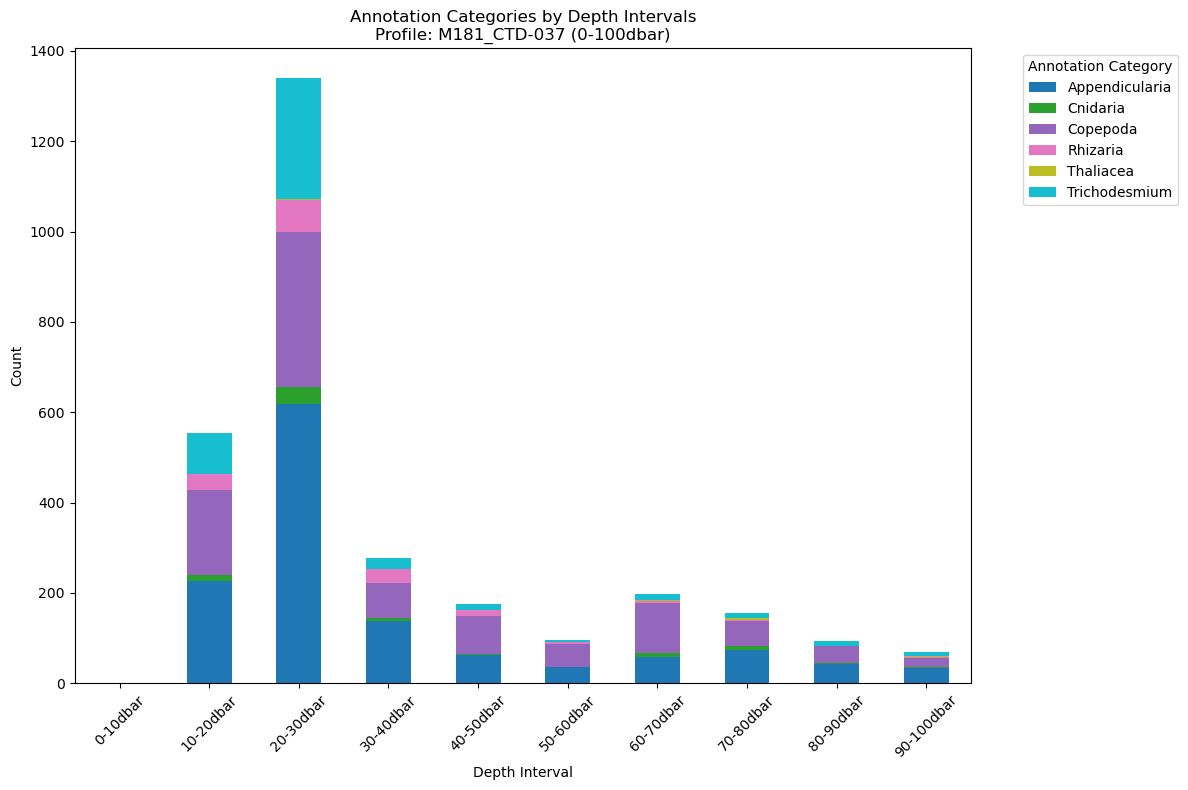


Summary table for M181_CTD-037:
object_annotation_category  Appendicularia  Cnidaria  Copepoda  Rhizaria  \
depth_interval                                                             
0-10dbar                                 0         0         0         0   
10-20dbar                              227        13       187        36   
20-30dbar                              618        38       343        72   
30-40dbar                              137         7        77        31   
40-50dbar                               63         2        85        12   
50-60dbar                               36         1        50         5   
60-70dbar                               58         8       112         4   
70-80dbar                               74         8        56         2   
80-90dbar                               42         2        38         1   
90-100dbar                              34         2        21         2   

object_annotation_category  Thaliacea  Trichodesmium  

C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\884807235.py:62: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_biovolume = filtered_data_bv.groupby(['depth_interval', 'object_annotation_category'])['biovolume_mm3'].sum().unstack(fill_value=0)


<Figure size 1200x800 with 0 Axes>

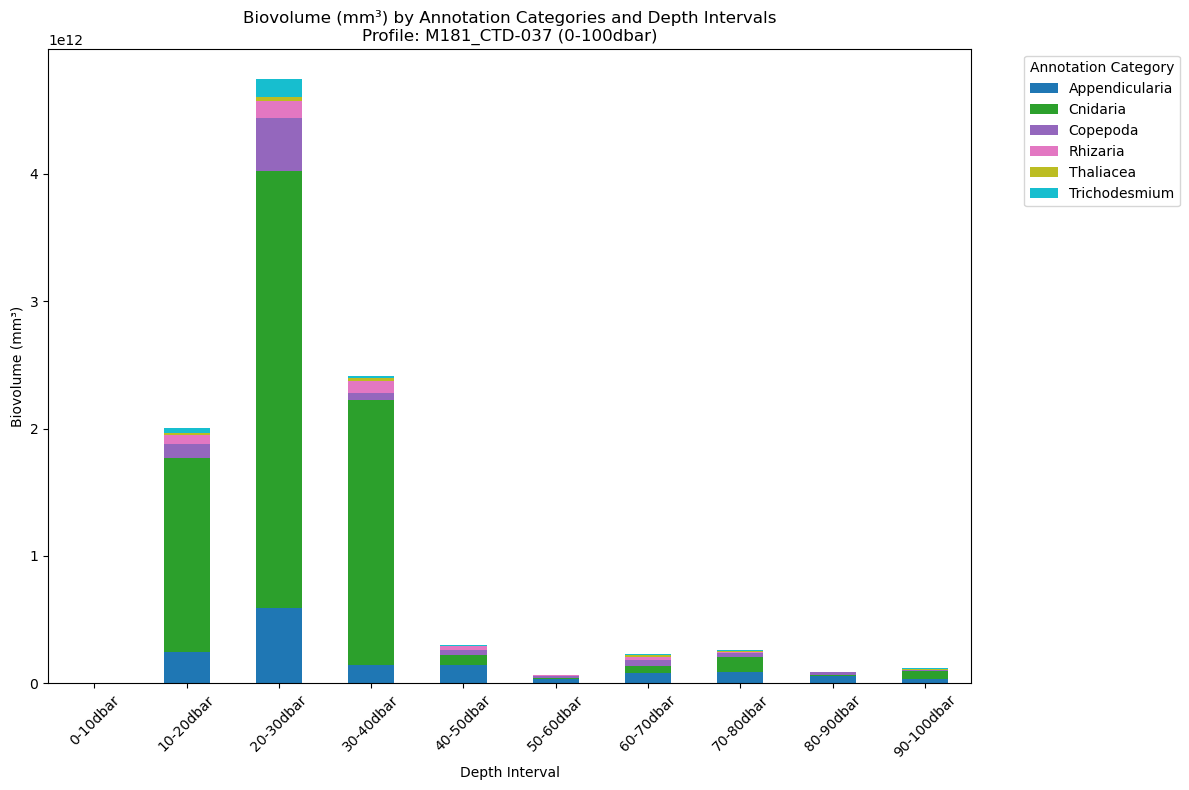


Biovolume summary table for M181_CTD-037 (mm³):
object_annotation_category  Appendicularia      Cnidaria      Copepoda  \
depth_interval                                                           
0-10dbar                      0.000000e+00  0.000000e+00  0.000000e+00   
10-20dbar                     2.434090e+11  1.527601e+12  1.064844e+11   
20-30dbar                     5.883008e+11  3.437523e+12  4.166479e+11   
30-40dbar                     1.417729e+11  2.082223e+12  5.658196e+10   
40-50dbar                     1.470611e+11  7.234713e+10  4.250907e+10   
50-60dbar                     3.580706e+10  2.296198e+09  1.998339e+10   
60-70dbar                     8.361824e+10  4.942172e+10  4.675698e+10   
70-80dbar                     9.145505e+10  1.118067e+11  3.836819e+10   
80-90dbar                     5.848778e+10  6.666331e+09  1.961216e+10   
90-100dbar                    3.647715e+10  5.878136e+10  9.896011e+09   

object_annotation_category      Rhizaria     Thaliacea  Tricho

In [6]:
# Filter data for specific profile and depth range
profile_name = "M181_CTD-037"
filtered_data = top6_validated_df[
    (top6_validated_df['profile'] == profile_name) & 
    (top6_validated_df['object_pressure'] >= 0) & 
    (top6_validated_df['object_pressure'] <= 100)
]

print(f"Filtered data shape: {filtered_data.shape}")
print(f"Depth range: {filtered_data['object_pressure'].min():.1f} - {filtered_data['object_pressure'].max():.1f} dbar")

# Create depth intervals (bins)
filtered_data = filtered_data.copy()
filtered_data['depth_interval'] = pd.cut(
    filtered_data['object_pressure'], 
    bins=range(0, 101, 10), 
    labels=[f"{i}-{i+10}dbar" for i in range(0, 100, 10)],
    include_lowest=True
)

# Group by depth interval and annotation category, count occurrences
grouped_data = filtered_data.groupby(['depth_interval', 'object_annotation_category']).size().unstack(fill_value=0)

print("\nAnnotation categories found:")
print(grouped_data.columns.tolist())

# Create stacked bar plot
plt.figure(figsize=(12, 8))
grouped_data.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab10')

plt.title(f'Annotation Categories by Depth Intervals\nProfile: {profile_name} (0-100dbar)')
plt.xlabel('Depth Interval')
plt.ylabel('Count')
plt.legend(title='Annotation Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display summary table
print(f"\nSummary table for {profile_name}:")
print(grouped_data)

# Filter data for specific profile and depth range (biovolume plot)
profile_name = "M181_CTD-037"
filtered_data_bv = top6_validated_df[
    (top6_validated_df['profile'] == profile_name) & 
    (top6_validated_df['object_pressure'] >= 0) & 
    (top6_validated_df['object_pressure'] <= 100)
].copy()

print(f"Filtered data shape for biovolume: {filtered_data_bv.shape}")

# Create depth intervals (bins)
filtered_data_bv['depth_interval'] = pd.cut(
    filtered_data_bv['object_pressure'], 
    bins=range(0, 101, 10), 
    labels=[f"{i}-{i+10}dbar" for i in range(0, 100, 10)],
    include_lowest=True
)

# Group by depth interval and annotation category, sum biovolume
grouped_biovolume = filtered_data_bv.groupby(['depth_interval', 'object_annotation_category'])['biovolume_mm3'].sum().unstack(fill_value=0)

print("\nBiovolume by annotation categories:")
print(grouped_biovolume.sum().sort_values(ascending=False))

# Create stacked bar plot for biovolume
plt.figure(figsize=(12, 8))
grouped_biovolume.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='tab10')

plt.title(f'Biovolume (mm³) by Annotation Categories and Depth Intervals\nProfile: {profile_name} (0-100dbar)')
plt.xlabel('Depth Interval')
plt.ylabel('Biovolume (mm³)')
plt.legend(title='Annotation Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display biovolume summary table
print(f"\nBiovolume summary table for {profile_name} (mm³):")
print(grouped_biovolume.round(6))

In [7]:
#print(all_images_df['sample_id'].unique())

# Define the 5 profiles of interest
selected_profiles = ['M181_CTD-037', 'M181_CTD-075', 'M181_CTD-060',
                    'M181_CTD-081', 'M181_CTD-050']

# Filter all_images_df for only these 5 profiles
profiles_5_all_images_df = all_images_df[all_images_df['profile'].isin(selected_profiles)]

print(f"\n=== 5 PROFILES ALL IMAGES DATAFRAME ===")
print(f"Original all_images_df shape: {all_images_df.shape}")
print(f"Filtered 5 profiles shape: {profiles_5_all_images_df.shape}")
print(f"Profiles in filtered data: {sorted(profiles_5_all_images_df['profile'].unique())}")
print(f"Images per profile:")
print(profiles_5_all_images_df['profile'].value_counts().sort_index())


=== 5 PROFILES ALL IMAGES DATAFRAME ===
Original all_images_df shape: (729407, 8)
Filtered 5 profiles shape: (91632, 8)
Profiles in filtered data: ['M181_CTD-037', 'M181_CTD-050', 'M181_CTD-060', 'M181_CTD-075', 'M181_CTD-081']
Images per profile:
profile
M181_CTD-037    24345
M181_CTD-050    20521
M181_CTD-060    13004
M181_CTD-075    16641
M181_CTD-081    17121
Name: count, dtype: int64


In [8]:
# Create binned datasets for each profile
selected_profiles = ['M181_CTD-037', 'M181_CTD-075', 'M181_CTD-060',
                    'M181_CTD-081', 'M181_CTD-050']

# Dictionary to store results for each profile
profile_datasets = {}

for profile in selected_profiles:
    print(f"\n=== Processing Profile: {profile} ===")
    
    # Filter validated data for this profile
    profile_validated = top6_validated_df[top6_validated_df['profile'] == profile].copy()
    
    # Filter images data for this profile  
    profile_images = profiles_5_all_images_df[profiles_5_all_images_df['profile'] == profile].copy()
    
    if len(profile_validated) == 0:
        print(f"No validated data found for {profile}")
        continue
        
    # Determine pressure range and create bins
    min_pressure = profile_validated['object_pressure'].min()
    max_pressure = profile_validated['object_pressure'].max()
    
    # Create bins in steps of 5 dbar
    bin_start = int(min_pressure // 5) * 5  # Round down to nearest 5
    bin_end = int(max_pressure // 5 + 1) * 5  # Round up to nearest 5
    
    pressure_bins = list(range(bin_start, bin_end + 5, 5))
    bin_labels = [f"{i}-{i+5}dbar" for i in pressure_bins[:-1]]
    
    print(f"Pressure range: {min_pressure:.1f} - {max_pressure:.1f} dbar")
    print(f"Bins: {pressure_bins}")
    
    # Create pressure bins for validated data
    profile_validated['pressure_bin'] = pd.cut(
        profile_validated['object_pressure'], 
        bins=pressure_bins, 
        labels=bin_labels,
        include_lowest=True
    )
    
    # Create pressure bins for images data
    profile_images['pressure_bin'] = pd.cut(
        profile_images['pressure'], 
        bins=pressure_bins, 
        labels=bin_labels,
        include_lowest=True
    )
    
    # Count individuals by category and bin
    counts_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category']).size().unstack(fill_value=0)
    
    # Sum biovolume by category and bin
    biovolume_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category'])['biovolume_mm3'].sum().unstack(fill_value=0)
    
    # Count images per bin and calculate sampled volume
    images_per_bin = profile_images.groupby('pressure_bin').size()
    sampled_volume_per_bin = images_per_bin * VOLUME_PER_IMAGE_LITERS
    
    # Create comprehensive dataset
    result_data = []
    
    for bin_label in bin_labels:
        if bin_label in counts_by_bin.index:
            bin_data = {
                'profile': profile,
                'pressure_bin': bin_label,
                'sampled_volume_L': sampled_volume_per_bin.get(bin_label, 0),
                'total_individuals': counts_by_bin.loc[bin_label].sum(),
                'total_biovolume_mm3': biovolume_by_bin.loc[bin_label].sum()
            }
            
            # Add counts for each category
            for category in counts_by_bin.columns:
                bin_data[f'count_{category}'] = counts_by_bin.loc[bin_label, category]
                
            # Add biovolume for each category  
            for category in biovolume_by_bin.columns:
                bin_data[f'biovolume_{category}_mm3'] = biovolume_by_bin.loc[bin_label, category]
                
            result_data.append(bin_data)
    
    # Create DataFrame for this profile
    profile_df = pd.DataFrame(result_data)
    profile_datasets[profile] = profile_df
    
    print(f"Dataset created with {len(profile_df)} pressure bins")
    print(f"Categories found: {counts_by_bin.columns.tolist()}")
    print(profile_df.head())

print(f"\n=== Summary ===")
print(f"Created datasets for {len(profile_datasets)} profiles")
for profile, df in profile_datasets.items():
    print(f"{profile}: {len(df)} bins, {df['total_individuals'].sum()} total individuals")



=== Processing Profile: M181_CTD-037 ===
Pressure range: 10.3 - 5277.5 dbar
Bins: [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320, 325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385, 390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450, 455, 460, 465, 470, 475, 480, 485, 490, 495, 500, 505, 510, 515, 520, 525, 530, 535, 540, 545, 550, 555, 560, 565, 570, 575, 580, 585, 590, 595, 600, 605, 610, 615, 620, 625, 630, 635, 640, 645, 650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710, 715, 720, 725, 730, 735, 740, 745, 750, 755, 760, 765, 770, 775, 780, 785, 790, 795, 800, 805, 810, 815, 820, 825, 830, 835, 840, 845, 850, 855, 860, 865, 870, 875, 880, 885, 890, 895, 900, 905, 910, 915, 920, 925, 930, 935, 940,

C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category']).size().unstack(fill_value=0)
C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  biovolume_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category'])['biovolume_mm3'].sum().unstack(fill_value=0)
C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:58: FutureWarning: The default of observed=False is deprecated and 

Dataset created with 1054 pressure bins
Categories found: ['Appendicularia', 'Cnidaria', 'Copepoda', 'Rhizaria', 'Thaliacea', 'Trichodesmium']
        profile pressure_bin  sampled_volume_L  total_individuals  \
0  M181_CTD-037    10-15dbar        248.225090                265   
1  M181_CTD-037    15-20dbar        269.391570                289   
2  M181_CTD-037    20-25dbar        885.143730               1098   
3  M181_CTD-037    25-30dbar        225.134384                242   
4  M181_CTD-037    30-35dbar        211.664805                194   

   total_biovolume_mm3  count_Appendicularia  count_Cnidaria  count_Copepoda  \
0         3.641519e+11                    91               4             111   
1         1.641306e+12                   136               9              76   
2         4.126245e+12                   519              29             271   
3         6.194434e+11                    99               9              72   
4         1.793392e+12                   1

C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category']).size().unstack(fill_value=0)
C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  biovolume_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category'])['biovolume_mm3'].sum().unstack(fill_value=0)
C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:58: FutureWarning: The default of observed=False is deprecated and 

Dataset created with 821 pressure bins
Categories found: ['Appendicularia', 'Cnidaria', 'Copepoda', 'Rhizaria', 'Thaliacea', 'Trichodesmium']
        profile pressure_bin  sampled_volume_L  total_individuals  \
0  M181_CTD-075    10-15dbar        294.406502                364   
1  M181_CTD-075    15-20dbar        311.724531                386   
2  M181_CTD-075    20-25dbar        727.357239                941   
3  M181_CTD-075    25-30dbar        271.315796                324   
4  M181_CTD-075    30-35dbar        309.800306                391   

   total_biovolume_mm3  count_Appendicularia  count_Cnidaria  count_Copepoda  \
0         1.275421e+12                   120               3             100   
1         6.480606e+11                   120               4             117   
2         7.102469e+11                   248              11             266   
3         9.813450e+11                    81               5              89   
4         2.732587e+11                    9

C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category']).size().unstack(fill_value=0)
C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  biovolume_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category'])['biovolume_mm3'].sum().unstack(fill_value=0)
C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:58: FutureWarning: The default of observed=False is deprecated and 

Dataset created with 666 pressure bins
Categories found: ['Appendicularia', 'Cnidaria', 'Copepoda', 'Rhizaria', 'Thaliacea', 'Trichodesmium']
        profile pressure_bin  sampled_volume_L  total_individuals  \
0  M181_CTD-060    10-15dbar        190.498325                598   
1  M181_CTD-060    15-20dbar        225.134384                858   
2  M181_CTD-060    20-25dbar        236.679737               1226   
3  M181_CTD-060    25-30dbar        225.134384               1261   
4  M181_CTD-060    30-35dbar        202.043678                901   

   total_biovolume_mm3  count_Appendicularia  count_Cnidaria  count_Copepoda  \
0         3.668145e+12                    40               4              85   
1         8.043449e+11                    37               5             103   
2         5.651024e+11                    40               7             102   
3         7.303294e+11                    32               9             134   
4         6.812533e+11                    2

C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category']).size().unstack(fill_value=0)
C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  biovolume_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category'])['biovolume_mm3'].sum().unstack(fill_value=0)
C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:58: FutureWarning: The default of observed=False is deprecated and 

Dataset created with 786 pressure bins
Categories found: ['Appendicularia', 'Cnidaria', 'Copepoda', 'Rhizaria', 'Thaliacea', 'Trichodesmium']
        profile pressure_bin  sampled_volume_L  total_individuals  \
0  M181_CTD-081     5-10dbar          1.924226                  2   
1  M181_CTD-081    10-15dbar        300.179178                544   
2  M181_CTD-081    15-20dbar        305.951855                548   
3  M181_CTD-081    20-25dbar       2653.506965               4709   
4  M181_CTD-081    25-30dbar        275.164247                434   

   total_biovolume_mm3  count_Appendicularia  count_Cnidaria  count_Copepoda  \
0         9.635058e+08                     0               0               1   
1         4.678554e+11                    79               7             122   
2         4.256148e+11                    77               8             135   
3         4.781387e+12                   634              78            1217   
4         3.424147e+11                    4

C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:52: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category']).size().unstack(fill_value=0)
C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:55: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  biovolume_by_bin = profile_validated.groupby(['pressure_bin', 'object_annotation_category'])['biovolume_mm3'].sum().unstack(fill_value=0)
C:\Users\fanny\AppData\Local\Temp\ipykernel_19544\2361409496.py:58: FutureWarning: The default of observed=False is deprecated and 

Dataset created with 889 pressure bins
Categories found: ['Appendicularia', 'Cnidaria', 'Copepoda', 'Rhizaria', 'Thaliacea', 'Trichodesmium']
        profile pressure_bin  sampled_volume_L  total_individuals  \
0  M181_CTD-050     5-10dbar          1.924226                 12   
1  M181_CTD-050    10-15dbar        271.315796               1328   
2  M181_CTD-050    15-20dbar        348.284816               1639   
3  M181_CTD-050    20-25dbar        885.143730               4340   
4  M181_CTD-050    25-30dbar        271.315796               1322   

   total_biovolume_mm3  count_Appendicularia  count_Cnidaria  count_Copepoda  \
0         8.504605e+09                     0               0               3   
1         2.968786e+12                    23              14             161   
2         5.211351e+12                    28              24             190   
3         1.912442e+13                    71              39             470   
4         2.647505e+12                    2

In [9]:
# Add normalized columns to each profile dataset
print("=== Adding normalized columns to profile datasets ===\n")

for profile, profile_df in profile_datasets.items():
    print(f"Processing {profile}...")
    
    # Get all count and biovolume columns for this profile
    count_cols = [col for col in profile_df.columns if col.startswith('count_')]
    biovolume_cols = [col for col in profile_df.columns if col.startswith('biovolume_') and col.endswith('_mm3')]
    
    # Add normalized count columns (individuals per liter)
    for count_col in count_cols:
        category = count_col.replace('count_', '')
        norm_col_name = f'count_per_L_{category}'
        
        # Avoid division by zero by replacing 0 with NaN
        safe_volume = profile_df['sampled_volume_L'].replace(0, np.nan)
        profile_df[norm_col_name] = profile_df[count_col] / safe_volume
    
    # Add normalized biovolume columns (biovolume per liter)
    for biovolume_col in biovolume_cols:
        category = biovolume_col.replace('biovolume_', '').replace('_mm3', '')
        norm_col_name = f'biovolume_per_L_{category}_mm3'
        
        # Avoid division by zero by replacing 0 with NaN
        safe_volume = profile_df['sampled_volume_L'].replace(0, np.nan)
        profile_df[norm_col_name] = profile_df[biovolume_col] / safe_volume
    
    # Add total normalized columns
    profile_df['total_individuals_per_L'] = profile_df['total_individuals'] / profile_df['sampled_volume_L'].replace(0, np.nan)
    profile_df['total_biovolume_per_L_mm3'] = profile_df['total_biovolume_mm3'] / profile_df['sampled_volume_L'].replace(0, np.nan)
    
    print(f"  Added {len(count_cols)} normalized count columns")
    print(f"  Added {len(biovolume_cols)} normalized biovolume columns")
    print(f"  New shape: {profile_df.shape}")

# Show example of normalized columns for first profile
first_profile = list(profile_datasets.keys())[0]
example_df = profile_datasets[first_profile]

print(f"\n=== Example: Normalized columns for {first_profile} ===")
norm_cols = [col for col in example_df.columns if 'per_L' in col]
print(f"Normalized columns created: {norm_cols}")

# Display sample data
display_cols = ['pressure_bin', 'sampled_volume_L', 'total_individuals_per_L', 'total_biovolume_per_L_mm3']
print(f"\nSample data:")
print(example_df[display_cols].head())

#save data as csv
for profile, df in profile_datasets.items():
    filename = f"{profile}_binned_data.csv"
    df.to_csv(filename, index=False)
    print(f"Saved {filename}")

=== Adding normalized columns to profile datasets ===

Processing M181_CTD-037...
  Added 6 normalized count columns
  Added 6 normalized biovolume columns
  New shape: (1054, 31)
Processing M181_CTD-075...
  Added 6 normalized count columns
  Added 6 normalized biovolume columns
  New shape: (821, 31)
Processing M181_CTD-060...
  Added 6 normalized count columns
  Added 6 normalized biovolume columns
  New shape: (666, 31)
Processing M181_CTD-081...
  Added 6 normalized count columns
  Added 6 normalized biovolume columns
  New shape: (786, 31)
Processing M181_CTD-050...
  Added 6 normalized count columns
  Added 6 normalized biovolume columns
  New shape: (889, 31)

=== Example: Normalized columns for M181_CTD-037 ===
Normalized columns created: ['count_per_L_Appendicularia', 'count_per_L_Cnidaria', 'count_per_L_Copepoda', 'count_per_L_Rhizaria', 'count_per_L_Thaliacea', 'count_per_L_Trichodesmium', 'biovolume_per_L_Appendicularia_mm3', 'biovolume_per_L_Cnidaria_mm3', 'biovolume_per_

Loaded dataset shape: (1054, 31)
Columns: ['profile', 'pressure_bin', 'sampled_volume_L', 'total_individuals', 'total_biovolume_mm3', 'count_Appendicularia', 'count_Cnidaria', 'count_Copepoda', 'count_Rhizaria', 'count_Thaliacea', 'count_Trichodesmium', 'biovolume_Appendicularia_mm3', 'biovolume_Cnidaria_mm3', 'biovolume_Copepoda_mm3', 'biovolume_Rhizaria_mm3', 'biovolume_Thaliacea_mm3', 'biovolume_Trichodesmium_mm3', 'count_per_L_Appendicularia', 'count_per_L_Cnidaria', 'count_per_L_Copepoda', 'count_per_L_Rhizaria', 'count_per_L_Thaliacea', 'count_per_L_Trichodesmium', 'biovolume_per_L_Appendicularia_mm3', 'biovolume_per_L_Cnidaria_mm3', 'biovolume_per_L_Copepoda_mm3', 'biovolume_per_L_Rhizaria_mm3', 'biovolume_per_L_Thaliacea_mm3', 'biovolume_per_L_Trichodesmium_mm3', 'total_individuals_per_L', 'total_biovolume_per_L_mm3']
Filtered dataset shape (0-100 dbar): (19, 31)
Categories found: ['Appendicularia', 'Cnidaria', 'Copepoda', 'Rhizaria', 'Thaliacea', 'Trichodesmium']


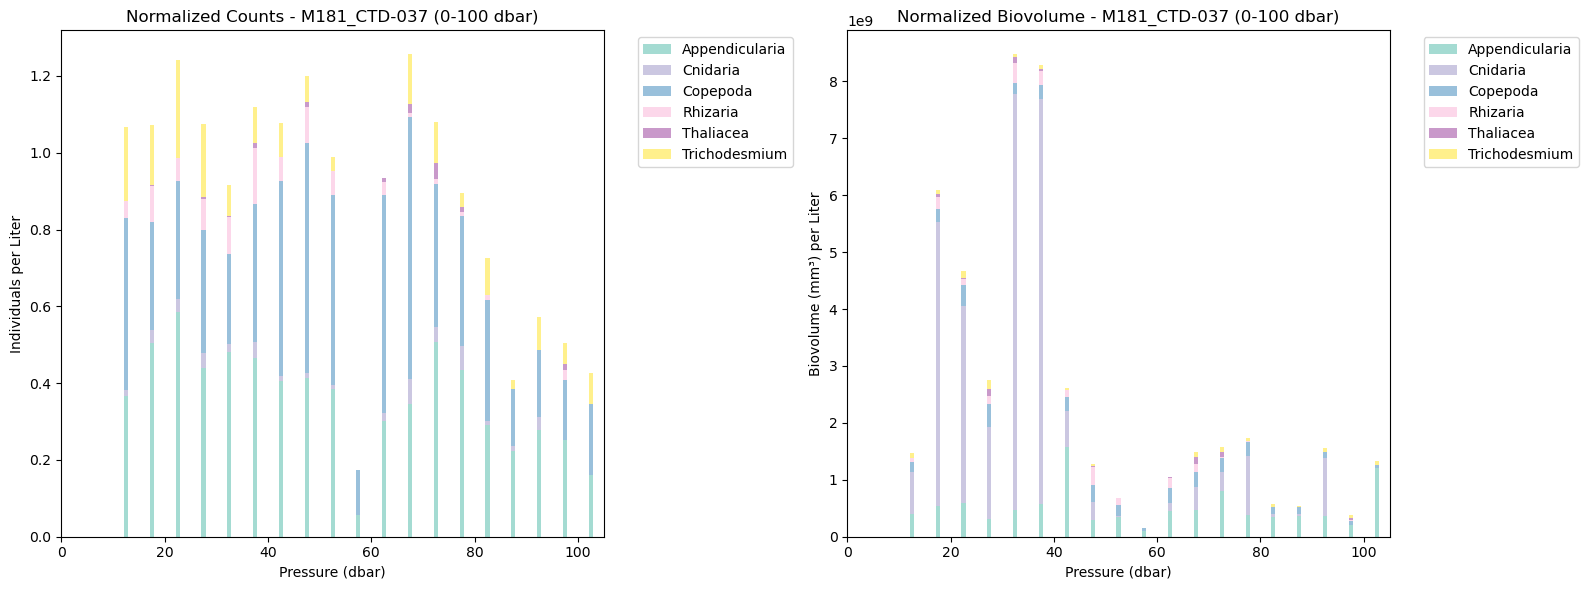


=== SUMMARY STATISTICS for M181_CTD-037 (0-100 dbar) ===
Total individuals per L: 0.88
Total biovolume per L: 2457172450.841486 mm³

Data by depth bin:
   pressure_bin  total_individuals_per_L  total_biovolume_per_L_mm3
0     10-15dbar                 1.067579               1.467023e+09
1     15-20dbar                 1.072788               6.092639e+09
2     20-25dbar                 1.240477               4.661666e+09
3     25-30dbar                 1.074914               2.751438e+09
4     30-35dbar                 0.916543               8.472794e+09
5     35-40dbar                 1.119331               8.280162e+09
6     40-45dbar                 1.077405               2.615182e+09
7     45-50dbar                 1.199284               1.279007e+09
8     50-55dbar                 0.989885               6.839391e+08
9     55-60dbar                 0.173230               1.453863e+08
10    60-65dbar                 0.935441               1.043717e+09
11    65-70dbar                

In [10]:
# Load the saved dataset for M181_CTD-037
profile_name = "M181_CTD-037"
dataset = pd.read_csv(f"{profile_name}_binned_data.csv")

print(f"Loaded dataset shape: {dataset.shape}")
print(f"Columns: {dataset.columns.tolist()}")

# Filter data to only include bins up to 100 dbar
depth_filter = []
for bin_label in dataset['pressure_bin']:
    start_depth = int(bin_label.split('-')[0])
    depth_filter.append(start_depth <= 100)

filtered_dataset = dataset[depth_filter].copy()
print(f"Filtered dataset shape (0-100 dbar): {filtered_dataset.shape}")

# Get normalized count and biovolume columns
norm_count_cols = [col for col in filtered_dataset.columns if col.startswith('count_per_L_')]
norm_biovolume_cols = [col for col in filtered_dataset.columns if col.startswith('biovolume_per_L_') and col.endswith('_mm3')]

# Extract categories
categories = [col.replace('count_per_L_', '') for col in norm_count_cols]
print(f"Categories found: {categories}")

# Extract depth values for x-axis (middle of each bin)
depth_values = []
for bin_label in filtered_dataset['pressure_bin']:
    start_depth = int(bin_label.split('-')[0])
    depth_values.append(start_depth + 2.5)  # Middle of 5 dbar bin

# Create colors for categories
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
color_map = dict(zip(categories, colors))

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot normalized counts (individuals per liter)
bottom_counts = np.zeros(len(filtered_dataset))
for category in categories:
    norm_count_col = f'count_per_L_{category}'
    if norm_count_col in filtered_dataset.columns:
        values = filtered_dataset[norm_count_col].fillna(0)
        ax1.bar(depth_values, values, bottom=bottom_counts, 
                label=category, color=color_map[category], alpha=0.8)
        bottom_counts += values

ax1.set_title(f'Normalized Counts - {profile_name} (0-100 dbar)', fontsize=12)
ax1.set_xlabel('Pressure (dbar)')
ax1.set_ylabel('Individuals per Liter')
ax1.set_xlim(0, 105)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot normalized biovolume
bottom_biovolume = np.zeros(len(filtered_dataset))
for category in categories:
    norm_biovolume_col = f'biovolume_per_L_{category}_mm3'
    if norm_biovolume_col in filtered_dataset.columns:
        values = filtered_dataset[norm_biovolume_col].fillna(0)
        ax2.bar(depth_values, values, bottom=bottom_biovolume,
                label=category, color=color_map[category], alpha=0.8)
        bottom_biovolume += values

ax2.set_title(f'Normalized Biovolume - {profile_name} (0-100 dbar)', fontsize=12)
ax2.set_xlabel('Pressure (dbar)')
ax2.set_ylabel('Biovolume (mm³) per Liter')
ax2.set_xlim(0, 105)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Display summary statistics
print(f"\n=== SUMMARY STATISTICS for {profile_name} (0-100 dbar) ===")
print(f"Total individuals per L: {filtered_dataset['total_individuals_per_L'].mean():.2f}")
print(f"Total biovolume per L: {filtered_dataset['total_biovolume_per_L_mm3'].mean():.6f} mm³")

print(f"\nData by depth bin:")
display_cols = ['pressure_bin', 'total_individuals_per_L', 'total_biovolume_per_L_mm3']
print(filtered_dataset[display_cols])

Looking for these files: ['M181_CTD-037_binned_data.csv', 'M181_CTD-075_binned_data.csv', 'M181_CTD-060_binned_data.csv', 'M181_CTD-081_binned_data.csv', 'M181_CTD-050_binned_data.csv']
Successfully loaded M181_CTD-037_binned_data.csv
Successfully loaded M181_CTD-075_binned_data.csv
Successfully loaded M181_CTD-060_binned_data.csv
Successfully loaded M181_CTD-081_binned_data.csv
Successfully loaded M181_CTD-050_binned_data.csv

Successfully loaded 5 profiles
Profile totals shape: (5, 28)
Profiles loaded: ['M181_CTD-037', 'M181_CTD-075', 'M181_CTD-060', 'M181_CTD-081', 'M181_CTD-050']
Categories: ['Appendicularia', 'Cnidaria', 'Copepoda', 'Rhizaria', 'Thaliacea', 'Trichodesmium']


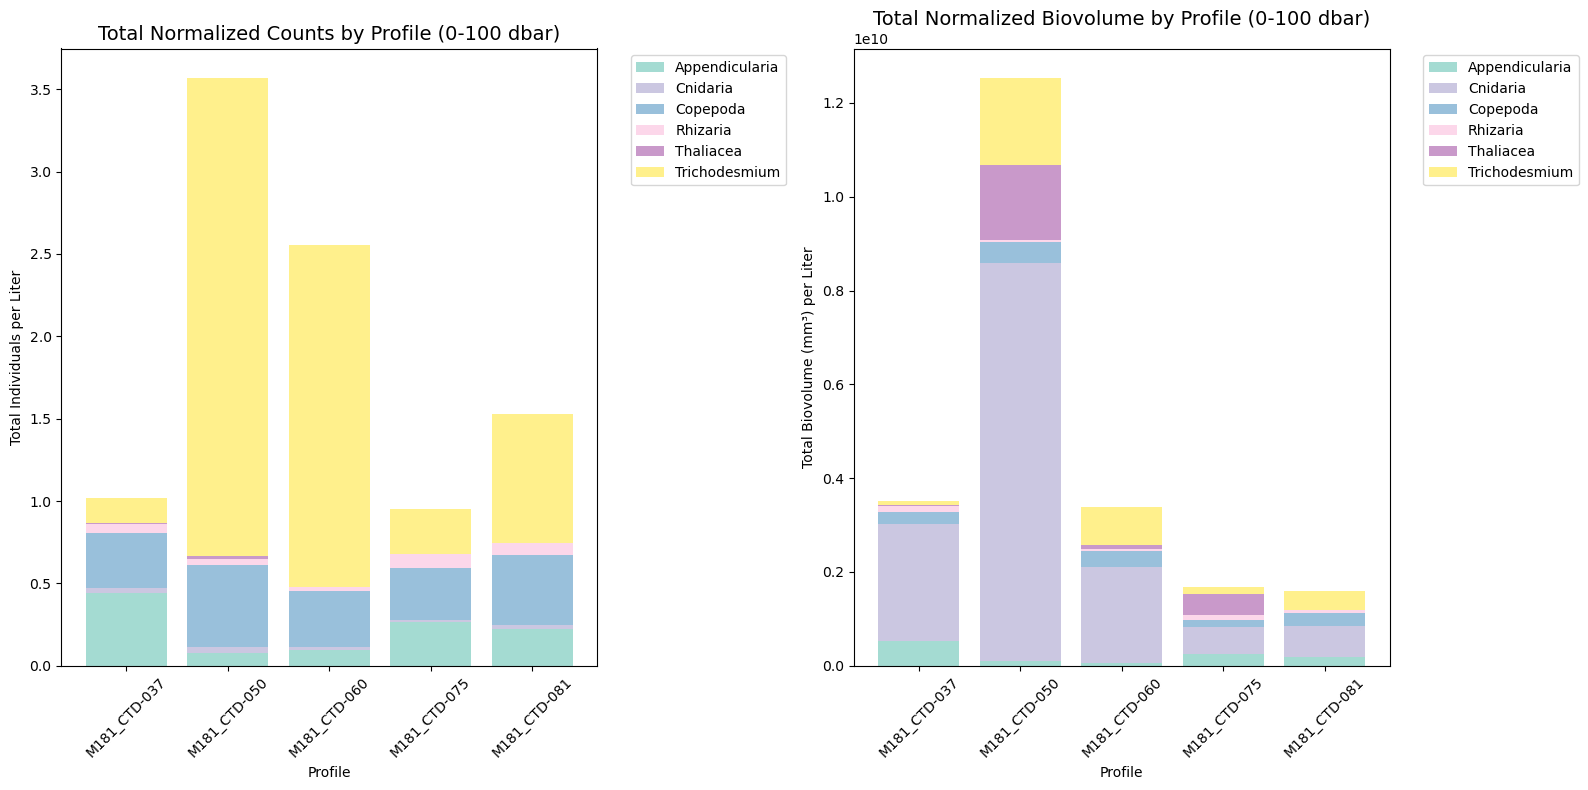


=== PROFILE COMPARISON SUMMARY (0-100 dbar) ===
              total_sampled_volume_L  total_individuals_per_L  \
M181_CTD-037             2940.216564                 1.016252   
M181_CTD-075             3076.836575                 0.953252   
M181_CTD-060             2203.238198                 2.556691   
M181_CTD-081             4820.184878                 1.531269   
M181_CTD-050             3159.578272                 3.569147   

              total_biovolume_per_L_mm3  
M181_CTD-037               3.514912e+09  
M181_CTD-075               1.677982e+09  
M181_CTD-060               3.373450e+09  
M181_CTD-081               1.601323e+09  
M181_CTD-050               1.253440e+10  


In [11]:
# Create a plot showing complete stacked data for every profile (no depth filter)

# Get the correct profile filenames based on what was actually saved
profile_files = []
for profile in ['M181_CTD-037', 'M181_CTD-075', 'M181_CTD-060', 'M181_CTD-081', 'M181_CTD-050']:
    filename = f"{profile}_binned_data.csv"
    profile_files.append(filename)

print("Looking for these files:", profile_files)

# Dictionary to store total values per profile
profile_totals = {}

for file in profile_files:
    try:
        df = pd.read_csv(file)
        profile_name = file.replace("_binned_data.csv", "")
        
        # Filter to 100 dbar
        depth_filter = []
        for bin_label in df['pressure_bin']:
            start_depth = int(bin_label.split('-')[0])
            depth_filter.append(start_depth <= 100)
        
        filtered_df = df[depth_filter]
        
        if len(filtered_df) > 0:
            # Calculate total normalized values across all depth bins
            norm_count_cols = [col for col in filtered_df.columns if col.startswith('count_per_L_')]
            norm_biovolume_cols = [col for col in filtered_df.columns if col.startswith('biovolume_per_L_') and col.endswith('_mm3')]
            
            categories = [col.replace('count_per_L_', '') for col in norm_count_cols]
            
            profile_data = {
                'profile': profile_name,
                'total_sampled_volume_L': filtered_df['sampled_volume_L'].sum(),
                'total_individuals': filtered_df['total_individuals'].sum(),
                'total_biovolume_mm3': filtered_df['total_biovolume_mm3'].sum()
            }
            
            # Sum counts and biovolume for each category across all depth bins
            for category in categories:
                count_col = f'count_{category}'
                biovolume_col = f'biovolume_{category}_mm3'
                
                if count_col in filtered_df.columns:
                    total_count = filtered_df[count_col].sum()
                    profile_data[f'total_count_{category}'] = total_count
                    profile_data[f'total_count_per_L_{category}'] = total_count / profile_data['total_sampled_volume_L']
                
                if biovolume_col in filtered_df.columns:
                    total_biovolume = filtered_df[biovolume_col].sum()
                    profile_data[f'total_biovolume_{category}_mm3'] = total_biovolume
                    profile_data[f'total_biovolume_per_L_{category}_mm3'] = total_biovolume / profile_data['total_sampled_volume_L']
            
            profile_totals[profile_name] = profile_data
            print(f"Successfully loaded {file}")
            
    except FileNotFoundError:
        print(f"File {file} not found, skipping...")
    except Exception as e:
        print(f"Error processing {file}: {e}")

print(f"\nSuccessfully loaded {len(profile_totals)} profiles")

# Only proceed if we have data
if len(profile_totals) > 0:
    # Create DataFrame from the collected data
    totals_df = pd.DataFrame.from_dict(profile_totals, orient='index')
    
    print("Profile totals shape:", totals_df.shape)
    print("Profiles loaded:", list(profile_totals.keys()))
    
    # Get categories from the first profile
    first_profile_data = list(profile_totals.values())[0]
    categories = []
    for key in first_profile_data.keys():
        if key.startswith('total_count_per_L_'):
            categories.append(key.replace('total_count_per_L_', ''))
    
    print(f"Categories: {categories}")
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Colors for categories
    colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
    color_map = dict(zip(categories, colors))
    
    profiles = list(profile_totals.keys())
    
    # Sort profiles by CTD number (extract number after CTD-)
    def extract_ctd_number(profile):
        return int(profile.split('CTD-')[1])
    
    profiles_sorted = sorted(profiles, key=extract_ctd_number)
    
    # Plot 1: Total normalized counts per profile
    bottom_counts = np.zeros(len(profiles_sorted))
    for category in categories:
        values = []
        for profile in profiles_sorted:
            col_name = f'total_count_per_L_{category}'
            values.append(profile_totals[profile].get(col_name, 0))
        
        ax1.bar(profiles_sorted, values, bottom=bottom_counts, 
                label=category, color=color_map[category], alpha=0.8)
        bottom_counts += np.array(values)
    
    ax1.set_title('Total Normalized Counts by Profile (0-100 dbar)', fontsize=14)
    ax1.set_xlabel('Profile')
    ax1.set_ylabel('Total Individuals per Liter')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Total normalized biovolume per profile
    bottom_biovolume = np.zeros(len(profiles_sorted))
    for category in categories:
        values = []
        for profile in profiles_sorted:
            col_name = f'total_biovolume_per_L_{category}_mm3'
            values.append(profile_totals[profile].get(col_name, 0))
        
        ax2.bar(profiles_sorted, values, bottom=bottom_biovolume,
                label=category, color=color_map[category], alpha=0.8)
        bottom_biovolume += np.array(values)
    
    ax2.set_title('Total Normalized Biovolume by Profile (0-100 dbar)', fontsize=14)
    ax2.set_xlabel('Profile')
    ax2.set_ylabel('Total Biovolume (mm³) per Liter')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Display summary table
    print(f"\n=== PROFILE COMPARISON SUMMARY (0-100 dbar) ===")
    display_df = totals_df[['total_sampled_volume_L']].copy()
    display_df['total_individuals_per_L'] = totals_df['total_individuals'] / totals_df['total_sampled_volume_L']
    display_df['total_biovolume_per_L_mm3'] = totals_df['total_biovolume_mm3'] / totals_df['total_sampled_volume_L']
    
    print(display_df.round(6))
else:
    print("No profile data loaded successfully. Check file paths and names.")

Full profile totals shape: 5
Profiles loaded: ['M181_CTD-037', 'M181_CTD-075', 'M181_CTD-060', 'M181_CTD-081', 'M181_CTD-050']
Categories: ['Appendicularia', 'Cnidaria', 'Copepoda', 'Rhizaria', 'Thaliacea', 'Trichodesmium']


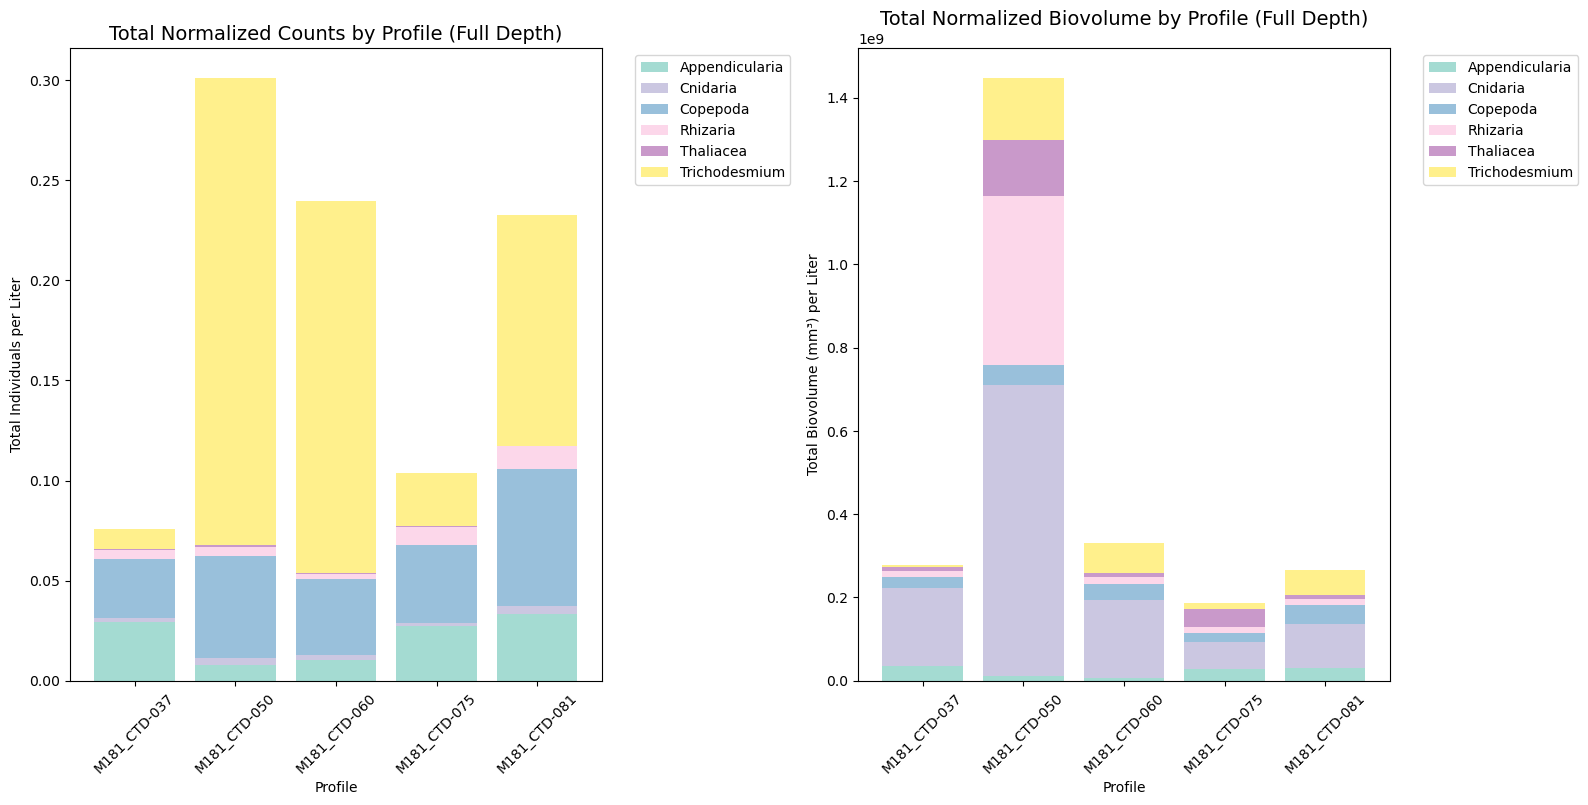


=== PROFILE COMPARISON SUMMARY (Full Depth) ===
              total_sampled_volume_L  total_individuals_per_L  \
M181_CTD-037            46845.269805                 0.075803   
M181_CTD-075            32015.263874                 0.103857   
M181_CTD-060            24766.706415                 0.239798   
M181_CTD-081            32936.967889                 0.232474   
M181_CTD-050            39487.031492                 0.300909   

              total_biovolume_per_L_mm3  
M181_CTD-037               2.788059e+08  
M181_CTD-075               1.871429e+08  
M181_CTD-060               3.298929e+08  
M181_CTD-081               2.654333e+08  
M181_CTD-050               1.446266e+09  

=== COMPARISON: 0-100 dbar vs Full Depth ===
        Profile  Individuals_per_L_0-100  Individuals_per_L_Full  \
0  M181_CTD-037                 1.016252                0.075803   
1  M181_CTD-050                 3.569147                0.300909   
2  M181_CTD-060                 2.556691                0.

In [12]:
# Create a plot showing complete stacked data for every profile (full depth range)

# Dictionary to store total values per profile (full depth)
profile_totals_full = {}

for file in profile_files:
    try:
        df = pd.read_csv(file)
        profile_name = file.replace("_binned_data.csv", "")
        
        # Use full dataset without depth filtering
        full_df = df.copy()
        
        if len(full_df) > 0:
            # Calculate total normalized values across all depth bins (full profile)
            norm_count_cols = [col for col in full_df.columns if col.startswith('count_per_L_')]
            norm_biovolume_cols = [col for col in full_df.columns if col.startswith('biovolume_per_L_') and col.endswith('_mm3')]
            
            categories = [col.replace('count_per_L_', '') for col in norm_count_cols]
            
            profile_data = {
                'profile': profile_name,
                'total_sampled_volume_L': full_df['sampled_volume_L'].sum(),
                'total_individuals': full_df['total_individuals'].sum(),
                'total_biovolume_mm3': full_df['total_biovolume_mm3'].sum()
            }
            
            # Sum counts and biovolume for each category across all depth bins
            for category in categories:
                count_col = f'count_{category}'
                biovolume_col = f'biovolume_{category}_mm3'
                
                if count_col in full_df.columns:
                    total_count = full_df[count_col].sum()
                    profile_data[f'total_count_{category}'] = total_count
                    profile_data[f'total_count_per_L_{category}'] = total_count / profile_data['total_sampled_volume_L']
                
                if biovolume_col in full_df.columns:
                    total_biovolume = full_df[biovolume_col].sum()
                    profile_data[f'total_biovolume_{category}_mm3'] = total_biovolume
                    profile_data[f'total_biovolume_per_L_{category}_mm3'] = total_biovolume / profile_data['total_sampled_volume_L']
            
            profile_totals_full[profile_name] = profile_data
            
    except FileNotFoundError:
        print(f"File {file} not found, skipping...")

print("Full profile totals shape:", len(profile_totals_full))
print("Profiles loaded:", list(profile_totals_full.keys()))

# Get categories from the first profile
first_profile_data = list(profile_totals_full.values())[0]
categories = []
for key in first_profile_data.keys():
    if key.startswith('total_count_per_L_'):
        categories.append(key.replace('total_count_per_L_', ''))

print(f"Categories: {categories}")

# Create figure with two subplots for full depth comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Colors for categories
colors = plt.cm.Set3(np.linspace(0, 1, len(categories)))
color_map = dict(zip(categories, colors))

profiles = list(profile_totals_full.keys())
# Use full profile names instead of shortened ones
def extract_ctd_number(profile):
    return int(profile.split('CTD-')[1])

profiles_sorted = sorted(profiles, key=extract_ctd_number)
profile_labels = profiles_sorted

# Plot 1: Total normalized counts per profile (full depth)
bottom_counts = np.zeros(len(profiles_sorted))
for category in categories:
    values = []
    for profile in profiles_sorted:
        col_name = f'total_count_per_L_{category}'
        values.append(profile_totals_full[profile].get(col_name, 0))
    
    ax1.bar(profile_labels, values, bottom=bottom_counts, 
            label=category, color=color_map[category], alpha=0.8)
    bottom_counts += np.array(values)

ax1.set_title('Total Normalized Counts by Profile (Full Depth)', fontsize=14)
ax1.set_xlabel('Profile')
ax1.set_ylabel('Total Individuals per Liter')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Total normalized biovolume per profile (full depth)
bottom_biovolume = np.zeros(len(profiles_sorted))
for category in categories:
    values = []
    for profile in profiles_sorted:
        col_name = f'total_biovolume_per_L_{category}_mm3'
        values.append(profile_totals_full[profile].get(col_name, 0))
    
    ax2.bar(profile_labels, values, bottom=bottom_biovolume,
            label=category, color=color_map[category], alpha=0.8)
    bottom_biovolume += np.array(values)

ax2.set_title('Total Normalized Biovolume by Profile (Full Depth)', fontsize=14)
ax2.set_xlabel('Profile')
ax2.set_ylabel('Total Biovolume (mm³) per Liter')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display summary table for full depth
print(f"\n=== PROFILE COMPARISON SUMMARY (Full Depth) ===")
totals_df_full = pd.DataFrame.from_dict(profile_totals_full, orient='index')

display_df_full = totals_df_full[['total_sampled_volume_L']].copy()
display_df_full['total_individuals_per_L'] = totals_df_full['total_individuals'] / totals_df_full['total_sampled_volume_L']
display_df_full['total_biovolume_per_L_mm3'] = totals_df_full['total_biovolume_mm3'] / totals_df_full['total_sampled_volume_L']

print(display_df_full.round(6))

# Compare 0-100 dbar vs full depth
print(f"\n=== COMPARISON: 0-100 dbar vs Full Depth ===")
comparison_df = pd.DataFrame({
    'Profile': profile_labels,
    'Individuals_per_L_0-100': [totals_df.loc[p, 'total_individuals'] / totals_df.loc[p, 'total_sampled_volume_L'] for p in profiles_sorted],
    'Individuals_per_L_Full': [totals_df_full.loc[p, 'total_individuals'] / totals_df_full.loc[p, 'total_sampled_volume_L'] for p in profiles_sorted],
    'Biovolume_per_L_0-100': [totals_df.loc[p, 'total_biovolume_mm3'] / totals_df.loc[p, 'total_sampled_volume_L'] for p in profiles_sorted],
    'Biovolume_per_L_Full': [totals_df_full.loc[p, 'total_biovolume_mm3'] / totals_df_full.loc[p, 'total_sampled_volume_L'] for p in profiles_sorted]
})

print(comparison_df.round(6))

In [13]:
# Analyze copepoda group in 0-100 dbar pressure range

print("=== COPEPODA ANALYSIS (0-100 dbar) ===\n")

# Filter for copepoda in 0-100 dbar range across all profiles
copepoda_filtered = top6_validated_df[
    (top6_validated_df['object_annotation_category'] == 'Copepoda') & 
    (top6_validated_df['object_pressure'] >= 0) & 
    (top6_validated_df['object_pressure'] <= 100)
]

print(f"Total copepoda individuals (0-100 dbar): {len(copepoda_filtered)}")
print(f"Profiles with copepoda data: {sorted(copepoda_filtered['profile'].unique())}")

# Count copepoda by profile
copepoda_by_profile = copepoda_filtered['profile'].value_counts().sort_index()
print(f"\nCopepoda counts by profile:")
print(copepoda_by_profile)

# Calculate sampled volume for 0-100 dbar range for each profile
print(f"\n=== SAMPLED VOLUME CALCULATION (0-100 dbar) ===")

total_sampled_volume = 0
profile_volumes = {}

for profile in copepoda_filtered['profile'].unique():
    # Filter all_images for this profile and depth range
    profile_images = all_images_df[
        (all_images_df['profile'] == profile) & 
        (all_images_df['pressure'] >= 0) & 
        (all_images_df['pressure'] <= 100)
    ]
    
    image_count = len(profile_images)
    volume_L = image_count * VOLUME_PER_IMAGE_LITERS
    profile_volumes[profile] = {
        'images': image_count,
        'volume_L': volume_L
    }
    total_sampled_volume += volume_L
    
    print(f"{profile}: {image_count} images, {volume_L:.3f} L")

print(f"\nTotal sampled volume (0-100 dbar): {total_sampled_volume:.3f} L")

# Calculate copepoda density (individuals per liter)
print(f"\n=== COPEPODA DENSITY ===")
total_copepoda = len(copepoda_filtered)
overall_density = total_copepoda / total_sampled_volume if total_sampled_volume > 0 else 0

print(f"Total copepoda individuals: {total_copepoda}")
print(f"Total sampled volume: {total_sampled_volume:.3f} L")
print(f"Overall copepoda density: {overall_density:.3f} individuals/L")

# Density by profile
print(f"\nCopepoda density by profile:")
for profile in sorted(copepoda_by_profile.index):
    count = copepoda_by_profile[profile]
    volume = profile_volumes[profile]['volume_L']
    density = count / volume if volume > 0 else 0
    print(f"{profile}: {count} individuals / {volume:.3f} L = {density:.3f} ind/L")

# Total biovolume of copepoda
total_copepoda_biovolume = copepoda_filtered['biovolume_mm3'].sum()
biovolume_density = total_copepoda_biovolume / total_sampled_volume if total_sampled_volume > 0 else 0

print(f"\n=== COPEPODA BIOVOLUME ===")
print(f"Total copepoda biovolume: {total_copepoda_biovolume:.6f} mm³")
print(f"Biovolume density: {biovolume_density:.6f} mm³/L")

# Summary table
import pandas as pd
summary_data = []
for profile in sorted(profile_volumes.keys()):
    count = copepoda_by_profile.get(profile, 0)
    volume = profile_volumes[profile]['volume_L']
    biovolume = copepoda_filtered[copepoda_filtered['profile'] == profile]['biovolume_mm3'].sum()
    
    summary_data.append({
        'Profile': profile,
        'Copepoda_Count': count,
        'Sampled_Volume_L': volume,
        'Density_ind_per_L': count / volume if volume > 0 else 0,
        'Biovolume_mm3': biovolume,
        'Biovolume_per_L_mm3': biovolume / volume if volume > 0 else 0
    })

summary_df = pd.DataFrame(summary_data)
print(f"\n=== COPEPODA SUMMARY TABLE ===")
print(summary_df.round(6))

=== COPEPODA ANALYSIS (0-100 dbar) ===

Total copepoda individuals (0-100 dbar): 6288
Profiles with copepoda data: ['M181_CTD-037', 'M181_CTD-050', 'M181_CTD-060', 'M181_CTD-075', 'M181_CTD-081']

Copepoda counts by profile:
profile
M181_CTD-037     969
M181_CTD-050    1559
M181_CTD-060     739
M181_CTD-075     964
M181_CTD-081    2057
Name: count, dtype: int64

=== SAMPLED VOLUME CALCULATION (0-100 dbar) ===
M181_CTD-037: 1489 images, 2865.172 L
M181_CTD-075: 1559 images, 2999.868 L
M181_CTD-060: 1107 images, 2130.118 L
M181_CTD-081: 2471 images, 4754.761 L
M181_CTD-050: 1601 images, 3080.685 L

Total sampled volume (0-100 dbar): 15830.603 L

=== COPEPODA DENSITY ===
Total copepoda individuals: 6288
Total sampled volume: 15830.603 L
Overall copepoda density: 0.397 individuals/L

Copepoda density by profile:
M181_CTD-037: 969 individuals / 2865.172 L = 0.338 ind/L
M181_CTD-050: 1559 individuals / 3080.685 L = 0.506 ind/L
M181_CTD-060: 739 individuals / 2130.118 L = 0.347 ind/L
M181_CTD

In [14]:
# Create detailed table of every Copepoda individual (0-100 dbar)
print("=== DETAILED COPEPODA INDIVIDUAL TABLE (0-100 dbar) ===\n")

# Create table with requested columns
copepoda_details = copepoda_filtered[[
    'object_id',
    'object_area',
    'object_esd',
    'biovolume_mm3',
    'profile',
    'object_pressure'
]].copy()

# Rename columns for clarity
copepoda_details = copepoda_details.rename(columns={
    'object_id': 'Object_ID',
    'object_area': 'Pixel_Area',
    'object_esd': 'ESD_mm',
    'biovolume_mm3': 'Biovolume_mm3',
    'profile': 'Profile',
    'object_pressure': 'Pressure_dbar'
})

# Sort by profile and pressure
copepoda_details = copepoda_details.sort_values(['Profile', 'Pressure_dbar'])

print(f"Total Copepoda individuals: {len(copepoda_details)}")
print(f"\nFirst 20 individuals:")
print(copepoda_details.head(20))

print(f"\nLast 20 individuals:")
print(copepoda_details.tail(20))

# Display summary statistics
print(f"\n=== SUMMARY STATISTICS ===")
print(copepoda_details[['Pixel_Area', 'ESD_mm', 'Biovolume_mm3', 'Pressure_dbar']].describe())

# Count by profile
print(f"\n=== COUNT BY PROFILE ===")
print(copepoda_details['Profile'].value_counts().sort_index())

# Save to CSV
filename = "Copepoda_individuals_0-100dbar.csv"
copepoda_details.to_csv(filename, index=False)
print(f"\n=== TABLE SAVED ===")
print(f"Saved detailed table to: {filename}")
print(f"Total rows: {len(copepoda_details)}")
print(f"Columns: {copepoda_details.columns.tolist()}")

=== DETAILED COPEPODA INDIVIDUAL TABLE (0-100 dbar) ===

Total Copepoda individuals: 6288

First 20 individuals:
         Object_ID  Pixel_Area   ESD_mm  Biovolume_mm3       Profile  \
1054  112-115_1178      1001.5   964.15   4.692804e+08  M181_CTD-037   
1125   112-116_234      1435.0  1154.10   8.048759e+08  M181_CTD-037   
1643  112-128_1539       802.5   863.06   3.366058e+08  M181_CTD-037   
1730   112-130_215       800.5   861.98   3.353437e+08  M181_CTD-037   
1731    112-130_22      4003.5  1927.70   3.750740e+09  M181_CTD-037   
1756    112-131_63       794.0   858.48   3.312754e+08  M181_CTD-037   
1787    112-132_60       822.5   873.75   3.492691e+08  M181_CTD-037   
2937  112-1763_212       553.5   716.77   1.928138e+08  M181_CTD-037   
2941  112-1764_300      5123.5  2180.73   5.430056e+09  M181_CTD-037   
2945  112-1765_143       564.0   723.53   1.983208e+08  M181_CTD-037   
2948    112-1765_6       502.0   682.61   1.665392e+08  M181_CTD-037   
2949   112-1765_81     